# Model Explanation Binary

## Dataset & Model Loading

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti
from IPython.display import display
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text
from utils.bad_word_blurrer import blur_text
import warnings

df_train = pd.read_csv("../dataset/training_set.csv")  
df_train = df_train[['text', 'binary_label']]
df_train = df_train[
    df_train['text'].notna() & df_train['text'].str.strip().astype(bool)
]

X_text = df_train["text"].fillna("").astype(str)
y_binary = df_train["binary_label"].map({
    "cyberbullying": 1,
    "not_cyberbullying": 0
})
       
pipeline_binary = joblib.load("../model/binary/RandomForest_TF-IDF.pkl")

rf_model = pipeline_binary.named_steps["model"]          

tfidf_vectorizer_binary = pipeline_binary.named_steps["vectorizer"]

vocab = tfidf_vectorizer_binary.get_feature_names_out()
vocab = [blur_text(word) for word in vocab]

print("\nBinary pipeline steps:")
print(pipeline_binary.steps)
print("\nExtracted model types:")
print("Binary model:   ", type(rf_model))
print("Binary vocab size:   ", len(tfidf_vectorizer_binary.get_feature_names_out()))



Binary pipeline steps:
[('preprocessing', TextPreprocessor()), ('augment', SynonymAugmenterToBalance()), ('vectorizer', TfidfVectorizer(min_df=0.005)), ('model', RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=42))]

Extracted model types:
Binary model:    <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Binary vocab size:    321


## Local Binary Model Explanation

In [2]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 0)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

df_correct_examples = pd.read_csv("../dataset/selected_explanable_example.csv")

X_example_tfidf = tfidf_vectorizer_binary.transform(df_correct_examples["text"]).toarray().astype("float32")
feature_names = tfidf_vectorizer_binary.get_feature_names_out() 

for i in range(len(df_correct_examples)):
    label_id = df_correct_examples.loc[i, "label_id"]
    label_name = df_correct_examples.loc[i, "label_name"]
    text = df_correct_examples.loc[i, "text"]
    
    x = X_example_tfidf[i].reshape(1, -1)

    prediction, bias, contributions = ti.predict(rf_model, x)
    predicted_label_id = np.argmax(prediction)

    data = []
    for j in range(len(feature_names)):
        data.append({
            "feature": blur_text(feature_names[j]),
            "contribution": contributions[0][j][predicted_label_id], 
            "tfidf_value": x[0][j]
        })

    df_interp = pd.DataFrame(data)
    df_interp_sorted = df_interp.reindex(df_interp.contribution.abs().sort_values(ascending=False).index)

    print(f"\n=== TreeInterpreter Explanation ===")
    print(f"True class: {label_name}")
    print(f"Predicted class: {predicted_label_id}")
    print(f"Text preview: {text[:150]}...\n")
    print(f"Bias (expected value): {bias[0][predicted_label_id]:.4f}")
    print(f"Prediction (probabilities): {prediction[0]}")
    
    display(df_interp_sorted.head(25))
    print("=" * 100)



=== TreeInterpreter Explanation ===
True class: age
Predicted class: 1
Text preview: realli hope bulli gay school...

Bias (expected value): 0.5000
Prediction (probabilities): [0.234 0.766]


,feature,contribution,tfidf_value
232,school,0.180766,0.335520
32,bulli,0.145115,0.283278
92,g*y,0.065892,0.427410
116,high,-0.043878,0.000000
94,girl,-0.034279,0.000000
220,r**e,-0.024721,0.000000
173,mkr,0.022816,0.000000
134,joke,-0.022368,0.000000
223,realli,0.018964,0.519215
171,middl,-0.013784,0.000000



=== TreeInterpreter Explanation ===
True class: ethnicity
Predicted class: 1
Text preview: dumb nigger fuck...

Bias (expected value): 0.5000
Prediction (probabilities): [0. 1.]


,feature,contribution,tfidf_value
65,dumb,0.209906,0.597026
187,n****r,0.196146,0.592484
88,f**k,0.144600,0.540853
173,mkr,0.018358,0.000000
232,school,-0.008127,0.000000
116,high,-0.006126,0.000000
16,a*s,-0.004954,0.000000
220,r**e,-0.004876,0.000000
177,muslim,-0.004699,0.000000
94,girl,-0.004511,0.000000



=== TreeInterpreter Explanation ===
True class: gender
Predicted class: 1
Text preview: rt im sexist hate woman sport comment...

Bias (expected value): 0.5000
Prediction (probabilities): [0.01 0.99]


,feature,contribution,tfidf_value
239,sexist,0.244969,0.444443
306,woman,0.156792,0.415828
125,im,0.090007,0.315214
109,hate,0.074928,0.404231
228,rt,0.042706,0.291108
173,mkr,0.032040,0.000000
47,comment,0.023050,0.531085
232,school,-0.022331,0.000000
40,christian,-0.020823,0.000000
227,right,-0.015958,0.000000



=== TreeInterpreter Explanation ===
True class: other_cyberbullying
Predicted class: 1
Text preview: ugli ass think god roll call...

Bias (expected value): 0.5000
Prediction (probabilities): [0.0512 0.9488]


,feature,contribution,tfidf_value
33,call,0.245803,0.363735
16,a*s,0.136803,0.395257
285,ugli,0.116703,0.548222
271,think,0.065279,0.388403
173,mkr,0.043592,0.000000
97,g*d,0.034103,0.509965
88,f**k,-0.027217,0.000000
232,school,-0.024062,0.000000
65,dumb,-0.022082,0.000000
29,b***h,-0.020307,0.000000



=== TreeInterpreter Explanation ===
True class: religion
Predicted class: 1
Text preview: visit muslim countri see woke right your behead like british girl idiot thought vacat morocco good idea dont blond err mean stupid...

Bias (expected value): 0.5000
Prediction (probabilities): [0.006 0.994]


,feature,contribution,tfidf_value
122,idiot,0.172350,0.244607
177,muslim,0.166150,0.233977
94,girl,0.090015,0.219784
150,like,0.075719,0.208824
227,right,0.036641,0.265415
173,mkr,0.023155,0.000000
232,school,-0.022428,0.000000
32,bulli,-0.020399,0.000000
116,high,-0.018492,0.000000
51,countri,0.017816,0.334636



=== TreeInterpreter Explanation ===
True class: not_cyberbullying
Predicted class: 0
Text preview:   fact paid fruit cup coffe school insan...

Bias (expected value): 0.5000
Prediction (probabilities): [1. 0.]


,feature,contribution,tfidf_value
32,bulli,0.344839,0.000000
232,school,-0.153905,0.474639
116,high,0.039299,0.000000
173,mkr,-0.030576,0.000000
94,girl,0.025511,0.000000
76,fact,0.019487,0.880180
150,like,0.016383,0.000000
88,f**k,0.016371,0.000000
54,day,-0.012617,0.000000
65,dumb,0.012320,0.000000


## Global Binary Model Explanation


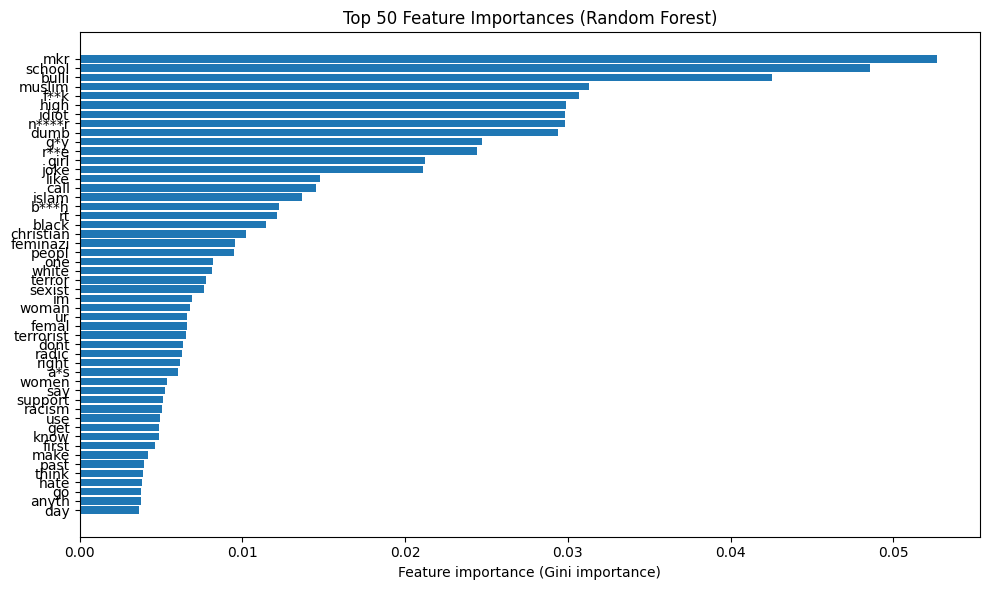

In [3]:
warnings.filterwarnings("ignore")

importances = rf_model.feature_importances_

feature_names = tfidf_vectorizer_binary.get_feature_names_out()

df_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_k = 50
df_top = df_importances.head(top_k)

df_top["feature"] = df_top["feature"].apply(blur_text)

plt.figure(figsize=(10, 6))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Feature importance (Gini importance)")
plt.title("Top 50 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

